<a href="https://colab.research.google.com/github/gomoore/colab-test/blob/main/GrowPig2025_Cordelia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# a. Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

In [ ]:
# b. Define time constraints of simulation

In [ ]:
tstart = 0
tstop = 10
cint = 0.1
maxt = 0.05

In [ ]:
time = np.arange(tstart,tstop+maxt,cint)
#  tstart, tstop, cint

In [ ]:
# c. Define value of constant parameters

In [ ]:
# Dietary Parameters - high CHO diet

FeedIntake = 0.888  # kg/d
CPcontent = 171    #g/kg
SScontent = 461     #g/kg
CFcontent = 33      #g/kg
NSPcontent = 150    #g/kg
DCprotein = 0.85    # g/kg
DCss = 1.0        #g/g
DCfat = 0.90      #g/g
DCnsp = 0.50      #g/g

"""FeedIntake = 0.790
CPcontent = 192
SScontent = 316
CFcontent = 136
NSPcontent = 168
DCprotein = 0.85    # g/kg
DCss = 1.0        #g/g
DCfat = 0.90      #g/g
DCnsp = 0.50      #g/g"""

# MM Equation Parameters

VmaxAAdeg = 250  # g/d
VmaxBPdep = 150  # g/d
VmaxGLox = 1000  # g/d
VmaxFAsyn = 300  # g/d
VmaxBFdep = 200  # g/d
AffinityBPdep = 2  # g/kg
AffinityAAdeg = 10  # g/kg
AffinityGLox = 10  # g/kg
AffinityFAsyn = 5  # g/kg
AffinityBFdep = 2  # g/kg
InhibitionGLforAAdeg = 2  # g/kg

# Other Constants & Parameters

kJgAA = 7.1     # kJ/g
kJgFA = 39.6    # kJ/g
kJgGL = 17.5    # kJ/g
EcostBPdeposition = 20  # kJ/g
EcostBFdeposition = 5    # kJ/g
EcostFAsynthesis = 3.3    # kJ/g
EcostUREAsynthesis = 5.3  # kJ/g
kJgGLforFAsyn = 5.8  # g/g
gFAgGL = 0.3  # g/g
gGLgAA = 0.74  # g/g
gUREAgAAdeg = 0.34  # g/g

# Define intitial pool values

iBodyWeight = 25  # kg
Aa0 = 5    #g
Gl0 = 5  # g
Atp0 = 10  # kJ
Fa0 = 5    #g
bP0 =  4000 # g
bF0 = 2500  # g


In [ ]:
# load initial pool values into a list called 'y0'
y0 = [0.0, Aa0, Gl0, Atp0, Fa0, bP0, bF0]

In [ ]:
# d. Define the model function

In [ ]:
def GrowPig(t,y, outputcall=0.0):

  outputcall, Aa, Gl, Atp, Fa, bP, bF = y

  # BodyWeight calculation

  BodyWater = 4.2 * bP     # g
  BodyAsh = 0.2 * bP      # g
  BodyWeight = ((bP + bF + BodyWater + BodyAsh)*1.06) / 1000  # kg


  # concentration calculations
  BloodVol = 0.08 * BodyWeight
  AAconc = Aa / BloodVol      #g/kg
  GLconc = Gl / BloodVol      # g/kg
  FAconc = Fa / BloodVol      # g/kg

  # Amino acid pool

  AAintake = FeedIntake * CPcontent * DCprotein    # g/d
  BPdep = (VmaxBPdep) / (1 + (AffinityBPdep / AAconc))      # g/d
  AAdeg = VmaxAAdeg / (1+ AffinityAAdeg/AAconc + GLconc/InhibitionGLforAAdeg)      # g/d

  dAAdt = AAintake - BPdep - AAdeg  #differential equation for AA pool

  UreaProduction = AAdeg * gUREAgAAdeg   # g/d

  # Glucose pool

  GLintake = FeedIntake * SScontent * DCss    #g/d
  GLfromAAdeg = AAdeg * gGLgAA    # g/d
  GLox = (VmaxGLox) / (1 + (AffinityGLox / GLconc))     # g/d
  GLforFAsyn = VmaxFAsyn / (1 + (AffinityFAsyn / GLconc))  # g/d

  dGLdt = GLintake + GLfromAAdeg - GLox - GLforFAsyn   # differential equation for Gl pool

  # Fatty acid pool

  FAintake = FeedIntake * CFcontent * DCfat     # g/d
  NSPintake = FeedIntake * NSPcontent * DCnsp      # g/d *
  BFdep = (VmaxBFdep) / (1 + (AffinityBFdep / FAconc))       # g/d
  FAsyn = GLforFAsyn * gFAgGL      # g/d

  # ATP pool

  ATPmaintenance = 450 * BodyWeight**0.75    # kJ/d
  ATPBFdep = BFdep * EcostBFdeposition    # kJ/d
  ATPBPdep = BPdep * EcostBPdeposition    # kJ/d
  ATPGLforFAsyn = GLforFAsyn * EcostFAsynthesis    # kJ/d
  ATPUREAprod = UreaProduction * EcostUREAsynthesis    # kJ/d

  ATPGlox = GLox * kJgGL   # kJ/d
  ATPAAdeg = AAdeg * kJgAA   # kJ/d
  ATPGLFA = FAsyn * kJgFA   # kJ/d

  ATPReq = ATPmaintenance + ATPBFdep + ATPBPdep + ATPGLforFAsyn + ATPUREAprod # ATP requirement sum
  ATPProd = ATPAAdeg + ATPGlox + ATPGLFA # ATP production sum (without FAox, closes gap)
  ATPFAox = ATPReq - ATPProd # kJ/d

  dATPdt = ATPGlox + ATPAAdeg + ATPGLFA + ATPFAox - ATPBPdep - ATPBFdep - ATPGLforFAsyn - ATPUREAprod - ATPmaintenance   # differential equation for ATP pool

  # FA pool

  # extra FA pool equations (down here so code is sorted correctly)
  FAox = ATPFAox / kJgFA    # g/d # Corrected ATPFAox instead of dATPdt
  dFAdt =  FAintake + NSPintake + FAsyn - BFdep - FAox   # differential equation for FA pool


  # Body protein pool

  dBPdt = BPdep

  # Body fat pool

  dBFdt = BFdep


  # Others

  HeatProduction = ATPReq    # kJ/d

  if outputcall == 1.0:
    return locals()


  return outputcall, dAAdt, dGLdt, dATPdt, dFAdt, dBPdt, dBFdt

In [ ]:
# e. Solve the model via numerical integration (dont need to change this)

In [ ]:
result = solve_ivp(GrowPig, t_span=(tstart,tstop), y0=y0, t_eval= time, max_step=maxt)

In [ ]:
# f. Prepare the outputs for visualization and printing (dont need to change this)

In [ ]:
def display_model_details(FUNC,X):
  final_list = []
  for i in range(len(X.y[0])):
    X.y[0, i] = 1
    outputs = FUNC(X.t[i], X.y[:,i], 1.0)
    outputs.pop('y')
    outputs.pop('outputcall')
    each_output = pd.DataFrame.from_dict(outputs,orient='index')
    final_list.append(each_output)
    final_df = pd.concat(final_list,axis=1).T
    final_df.index= np.arange(final_df.shape[0])
  return final_df

In [ ]:
the_df = display_model_details(GrowPig, result)
print(the_df.info())
print(the_df)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(the_df)

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 100
Data columns (total 45 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   t               101 non-null    float64
 1   Aa              101 non-null    float64
 2   Gl              101 non-null    float64
 3   Atp             101 non-null    float64
 4   Fa              101 non-null    float64
 5   bP              101 non-null    float64
 6   bF              101 non-null    float64
 7   BodyWater       101 non-null    float64
 8   BodyAsh         101 non-null    float64
 9   BodyWeight      101 non-null    float64
 10  BloodVol        101 non-null    float64
 11  AAconc          101 non-null    float64
 12  GLconc          101 non-null    float64
 13  FAconc          101 non-null    float64
 14  AAintake        101 non-null    float64
 15  BPdep           101 non-null    float64
 16  AAdeg           101 non-null    float64
 17  dAAdt           101 non-null    float64


,t,Aa,Gl,Atp,Fa,bP,bF,BodyWater,BodyAsh,BodyWeight,BloodVol,AAconc,GLconc,FAconc,AAintake,BPdep,AAdeg,dAAdt,UreaProduction,GLintake,GLfromAAdeg,GLox,GLforFAsyn,dGLdt,FAintake,NSPintake,BFdep,FAsyn,ATPmaintenance,ATPBFdep,ATPBPdep,ATPGLforFAsyn,ATPUREAprod,ATPGlox,ATPAAdeg,ATPGLFA,ATPReq,ATPProd,ATPFAox,dATPdt,FAox,dFAdt,dBPdt,dBFdt,HeatProduction
0,0.0,5.000000,5.000000,10.0,5.000000,4000.000000,2500.000000,16800.000000,800.000000,25.546000,2.043680,2.446567,2.446567,2.446567,129.0708,82.532221,39.615611,6.922968,13.469308,409.368,29.315552,196.565606,98.564895,143.553052,26.3736,66.6,110.042961,29.569469,5113.340277,550.214804,1650.644412,325.264154,71.387332,3439.898100,281.270841,1170.950954,7710.850978,4892.119895,2818.731083,9.094947e-13,71.180078,-58.679970,82.532221,110.042961,7710.850978
1,0.1,5.670974,8.595778,10.0,4.586077,4008.505232,2510.363962,16835.721973,801.701046,25.605670,2.048454,2.768417,4.196228,2.238800,129.0708,87.086043,37.256236,4.728521,12.667120,409.368,27.569615,295.587519,136.889642,4.460454,26.3736,66.6,105.633663,41.066893,5122.295379,528.168313,1741.720868,451.735818,67.135737,5172.781584,264.519275,1626.248945,7911.056116,7063.549804,847.506312,9.094947e-13,21.401675,7.005155,87.086043,105.633663,7911.056116
2,0.2,5.987656,8.755624,10.0,5.058502,4017.323345,2521.207352,16872.758048,803.464669,25.667639,2.053411,2.915956,4.263941,2.463463,129.0708,88.974225,38.101752,1.994823,12.954596,409.368,28.195297,298.931480,138.081870,0.549946,26.3736,66.6,110.383481,41.424561,5131.590009,551.917403,1779.484498,455.670172,68.659358,5231.300904,270.522442,1640.412619,7987.321439,7142.235964,845.085475,9.094947e-13,21.340542,2.674138,88.974225,110.383481,7987.321439
3,0.3,6.123823,8.793554,10.0,5.215686,4026.262529,2532.330369,16910.302621,805.252506,25.730597,2.058448,2.974971,4.271935,2.533796,129.0708,89.698142,38.477258,0.895399,13.082268,409.368,28.473171,299.324139,138.221463,0.295570,26.3736,66.6,111.773702,41.466439,5141.027296,558.868508,1793.962849,456.130828,69.336020,5238.172427,273.188535,1642.070979,8019.325499,7153.431940,865.893559,0.000000e+00,21.865999,0.800338,89.698142,111.773702,8019.325499
4,0.4,6.188109,8.820191,10.0,5.259258,4035.248881,2543.526944,16948.045300,807.049776,25.793903,2.063512,2.998823,4.274359,2.548692,129.0708,89.985878,38.629007,0.455915,13.133863,409.368,28.585465,299.443127,138.263747,0.246592,26.3736,66.6,112.062642,41.479124,5150.510922,560.313211,1799.717550,456.270366,69.609471,5240.254715,274.265952,1642.573317,8036.421520,7157.093984,879.327536,0.000000e+00,22.205241,0.184841,89.985878,112.062642,8036.421520
5,0.5,6.223468,8.843842,10.0,5.266058,4044.254163,2554.731843,16985.867483,808.850833,25.857327,2.068586,3.008561,4.275308,2.545728,129.0708,90.102558,38.690695,0.277547,13.154836,409.368,28.631114,299.489707,138.280298,0.229109,26.3736,66.6,112.005295,41.484089,5160.006269,560.026477,1802.051160,456.324984,69.720633,5241.069874,274.703935,1642.769943,8048.129523,7158.543753,889.585770,0.000000e+00,22.464287,-0.011893,90.102558,112.005295,8048.129523
6,0.6,6.247034,8.866349,10.0,5.261207,4053.267158,2565.924528,17023.722062,810.653432,25.920781,2.073662,3.012561,4.275695,2.537157,129.0708,90.150352,38.715976,0.204472,13.163432,409.368,28.649822,299.508718,138.287053,0.222051,26.3736,66.6,111.839061,41.486116,5169.500462,559.195303,1803.007044,456.347275,69.766189,5241.402573,274.883430,1642.850190,8057.816273,7159.136193,898.680080,0.000000e+00,22.693941,-0.073286,90.150352,111.839061,8057.816273
7,0.7,6.265757,8.888386,10.0,5.252774,4062.283321,2577.098591,17061.589947,812.456664,25.984234,2.078739,3.014211,4.275855,2.526905,129.0708,90.170047,38.726394,0.174359,13.166974,409.368,28.657532,299.516575,138.289844,0.219113,26.3736,66.6,111.639401,41.486953,5178.988607,558.197003,1803.400945,456.356486,69.784962,5241.540055,274.957397,1642.883350,8066.728003,7159.380802,907.347201,0.000000e+00,22.912808,-0.091655,90.170047,111.639401,8066.728003
8,0.8,6.2824

In [ ]:
#   Print Question 2 fluxes to examine:

print(the_df.Aa, the_df.Fa, the_df.Gl, the_df.Atp, the_df.bP, the_df.bF)

0      5.000000
1      5.670974
2      5.987656
3      6.123823
4      6.188109
         ...   
96     7.610256
97     7.625105
98     7.639949
99     7.654788
100    7.669622
Name: Aa, Length: 101, dtype: float64 0      5.000000
1      4.586077
2      5.058502
3      5.215686
4      5.259258
         ...   
96     4.427299
97     4.418463
98     4.409635
99     4.400814
100    4.392001
Name: Fa, Length: 101, dtype: float64 0       5.000000
1       8.595778
2       8.755624
3       8.793554
4       8.820191
         ...    
96     10.791094
97     10.812142
98     10.833183
99     10.854217
100    10.875244
Name: Gl, Length: 101, dtype: float64 0      10.0
1      10.0
2      10.0
3      10.0
4      10.0
       ... 
96     10.0
97     10.0
98     10.0
99     10.0
100    10.0
Name: Atp, Length: 101, dtype: float64 0      4000.000000
1      4008.505232
2      4017.323345
3      4026.262529
4      4035.248881
          ...     
96     4864.933089
97     4873.951803
98     4882.970521
99   

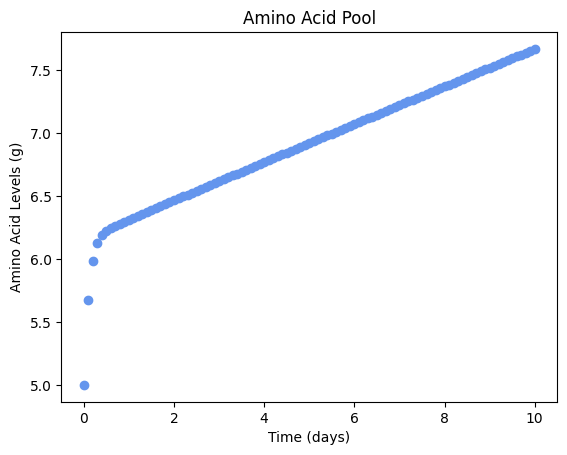

In [ ]:
from re import A
#   Print Question 3 fluxes to examine:

plt.scatter(the_df['t'],the_df['Aa'],c='cornflowerblue')
plt.xlabel('Time (days)')
plt.ylabel('Amino Acid Levels (g)')
plt.title('Amino Acid Pool')
plt.show()

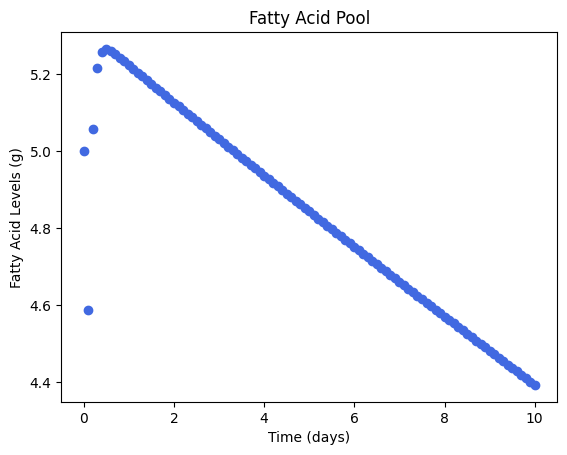

In [ ]:
plt.scatter(the_df['t'],the_df['Fa'],c='royalblue')
plt.xlabel('Time (days)')
plt.ylabel('Fatty Acid Levels (g)')
plt.title('Fatty Acid Pool')
plt.show()

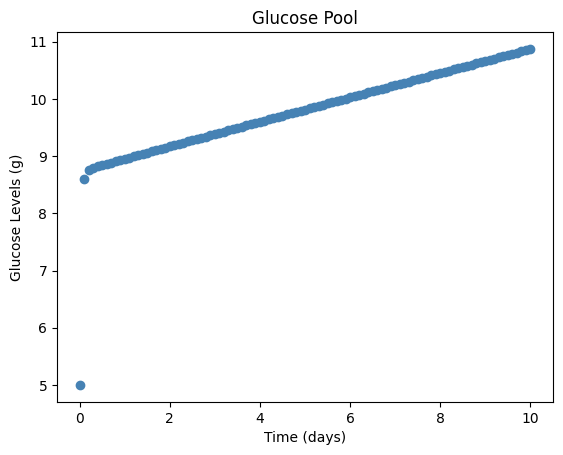

In [ ]:
plt.scatter(the_df['t'],the_df['Gl'],c='steelblue')
plt.xlabel('Time (days)')
plt.ylabel('Glucose Levels (g)')
plt.title('Glucose Pool')
plt.show()

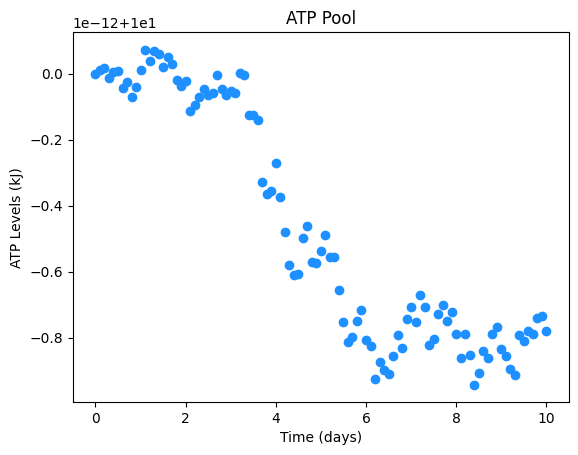

In [ ]:
plt.scatter(the_df['t'],the_df['Atp'],c='dodgerblue')
plt.xlabel('Time (days)')
plt.ylabel('ATP Levels (kJ)')
plt.title('ATP Pool')
plt.show()

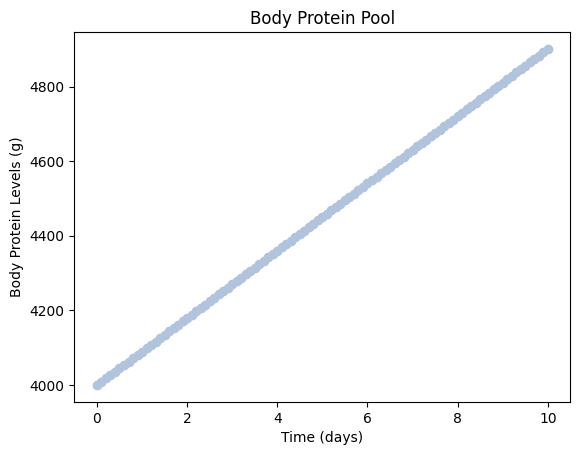

In [ ]:
plt.scatter(the_df['t'],the_df['bP'],c='lightsteelblue')
plt.xlabel('Time (days)')
plt.ylabel('Body Protein Levels (g)')
plt.title('Body Protein Pool')
plt.show()

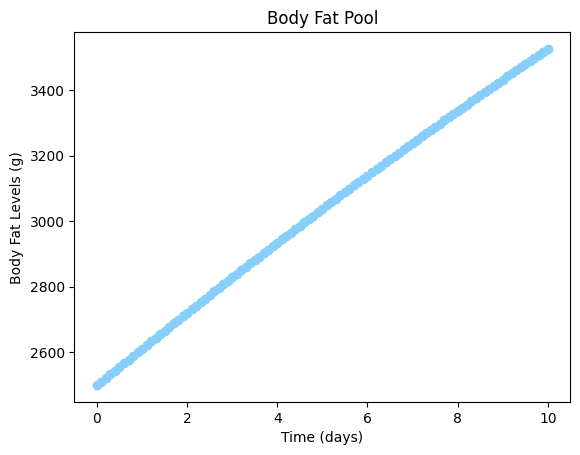

In [ ]:
plt.scatter(the_df['t'],the_df['bF'],c='lightskyblue')
plt.xlabel('Time (days)')
plt.ylabel('Body Fat Levels (g)')
plt.title('Body Fat Pool')
plt.show()

In [ ]:
vals10 = GrowPig(result.t[-1], result.y[:,-1])
Aa10 = vals10['Aa']
Fa10 = vals10['Fa']
Gl10 = vals10['Gl']
Atp10 = vals10['Atp']
bP10 = vals10['bP']
bF10 = vals10['bF']

print(f"Amino Acid Pool D10: {Aa10:.2f} g")
print(f"Fatty Acid Pool D10: {Fa10:.2f} g")
print(f"Glucose Pool D10: {Gl10:.2f} g")
print(f"ATP Pool D10: {Atp10:.2f} kJ")
print(f"Body Protein Pool D10: {bP10:.2f} g")
print(f"Body Fat Pool D10: {bF10:.2f} g")

Amino Acid Pool D10: 7.67 g
Fatty Acid Pool D10: 4.39 g
Glucose Pool D10: 10.88 g
ATP Pool D10: 10.00 kJ
Body Protein Pool D10: 4901.01 g
Body Fat Pool D10: 3525.95 g


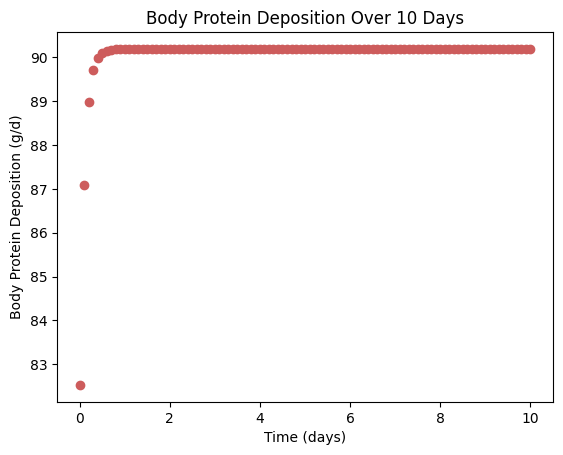

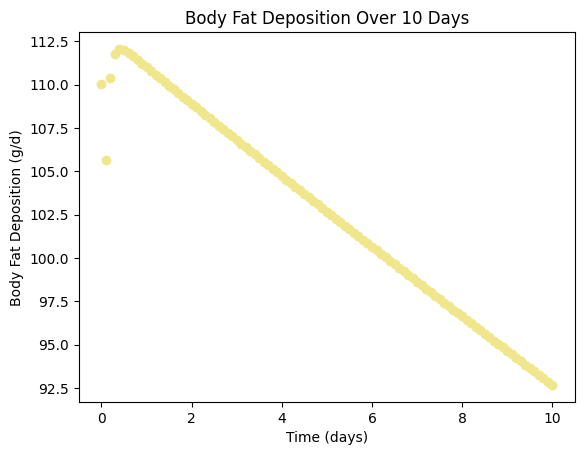

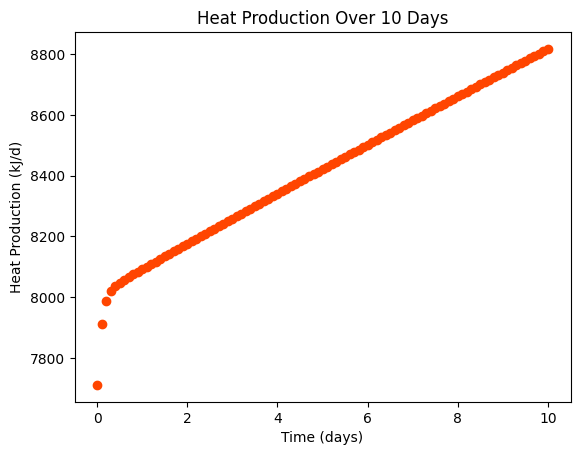

Body Fat Deposition D10: 92.67 g/d

Heat Production D10: 8818.03 kJ/d


In [ ]:
#  Plot Question 4 fluxes to examine:

# Assuming 'the_df' DataFrame containing 't', 'BFdep', and 'HeatProduction' is available from previous cells

plt.figure()
plt.scatter(the_df['t'], the_df['BPdep'], c='indianred')
plt.xlabel('Time (days)')
plt.ylabel('Body Protein Deposition (g/d)')
plt.title('Body Protein Deposition Over 10 Days')
plt.show()

plt.figure()
plt.scatter(the_df['t'], the_df['BFdep'], c='khaki')
plt.xlabel('Time (days)')
plt.ylabel('Body Fat Deposition (g/d)')
plt.title('Body Fat Deposition Over 10 Days')
plt.show()

plt.figure()
plt.scatter(the_df['t'], the_df['HeatProduction'], c='orangered')
plt.xlabel('Time (days)')
plt.ylabel('Heat Production (kJ/d)')
plt.title('Heat Production Over 10 Days')
plt.show()

# Print Question 4 fluxes to examine at Day 9 and Day 10

# Get data at Day 10
# Find the row corresponding to the last time point (Day 10)
row10 = the_df.iloc[-1]
BFdep10 = row10['BFdep']
HeatProd10 = row10['HeatProduction']


print(f"Body Fat Deposition D10: {BFdep10:.2f} g/d")

print(f"\nHeat Production D10: {HeatProd10:.2f} kJ/d")

In [ ]:
#  Print Question 5 fluxes to examine:

# Get data at Day 10
vals10 = GrowPig(result.t[-1], result.y[:,-1])
bw10 = vals10['BodyWeight'] # g/d
BPdep10 = vals10['BPdep'] # g/d
BFdep10 = vals10['BFdep'] # g/d
HeatProd10 = vals10['HeatProduction'] # kJ/d

# Get data at Day 9 (index 90 since time step is 0.1)
vals9 = GrowPig(result.t[90], result.y[:,90])
bw9 = vals9['BodyWeight']
BPdep9 = vals9['BPdep']
BFdep9 = vals9['BFdep']
HeatProd9 = vals9['HeatProduction']

print(f"Diet Parameters:")
print(f"\tBody Weight D10: {bw10:.2f} kg")
print(f"\tBody Weight D9: {bw9:.2f} kg")
print(f"\tBody Weight Change, D9 to D10: {bw10-bw9:.2f} kg")
print(f"\n\tBody Protein Deposition D10: {BPdep10:.2f} g")
print(f"\tBody Protein Deposition D9: {BPdep9:.2f} g")
print(f"\tBody Protein Deposition Change, D9 to D10: {BPdep10-BPdep9:.2f} g")
print(f"\n\tBody Fat Deposition D10: {BFdep10:.2f} g")
print(f"\tBody Fat Deposition D9: {BFdep9:.2f} g")
print(f"\tBody Fat Deposition Change, D9 to D10: {BFdep10-BFdep9:.2f} g")
print(f"\n\tHeat Production D10: {HeatProd10:.2f} kJ")
print(f"\tHeat Production D9: {HeatProd9:.2f} kJ")
print(f"\tHeat Production Change, D9 to D10: {HeatProd10-HeatProd9:.2f} kJ")


Diet Parameters:
	Body Weight D10: 31.79 kg
	Body Weight D9: 31.18 kg
	Body Weight Change, D9 to D10: 0.62 kg

	Body Protein Deposition D10: 90.19 g
	Body Protein Deposition D9: 90.19 g
	Body Protein Deposition Change, D9 to D10: 0.00 g

	Body Fat Deposition D10: 92.67 g
	Body Fat Deposition D9: 94.64 g
	Body Fat Deposition Change, D9 to D10: -1.97 g

	Heat Production D10: 8818.03 kJ
	Heat Production D9: 8740.16 kJ
	Heat Production Change, D9 to D10: 77.87 kJ


In [ ]:
# g. Plot results - Q3 & Q4